In [2]:
import os
import cv2
from PIL import Image
import pytesseract
import numpy as np
import onnxruntime as ort
from collections import deque
from itertools import groupby
from matplotlib import pyplot as plt
from skimage.filters import threshold_local
import torch

In [30]:
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')
def bw_scanner(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 21, offset = 5, method = "gaussian")
    return (gray > T).astype("uint8") * 255
# Function to preprocess images
def preprocess_image(image):
    # Load the image using OpenCV
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3,3), 0)

    # thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    # Morph open to remove noise and invert image
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    invert = 255 - opening

    return invert

In [ ]:
path = r"D:\photos\RCNN4\Lines\13-0.jpg"
path = r"D:\photos\SORIE\test\0a5bc7b5-c4c6-4066-a29b-a2940cded50c.jpg"
path = r"D:\photos\RCNN4\Lines\18-1.jpg"
path = r"D:\photos\RCNN4\Lines\27-1.jpg"
path = r"D:\photos\RCNN_new_data\combined\1806.png"
image = cv2.imread(path)
# processed_image = bw_scanner(image)
processed_image = preprocess_image(image)
plot_gray(processed_image)
extracted_text = pytesseract.image_to_string(processed_image, lang='eng', config='--psm 7 --oem 3')
print(f'Extracted Text:\n{extracted_text}\n')

In [43]:
import csv
image_dir = r"D:\photos\RCNN_new_data\combined"

data = []
num_data = 0

# Loop through each image in the directory
for filename in os.listdir(image_dir):
    if filename.endswith('.png') or filename.endswith('.jpg'):
        # Load the image
        image_path = os.path.join(image_dir, filename)
        image = cv2.imread(image_path)
        
        # Perform OCR
        processed_image = preprocess_image(image)
        extracted_text = pytesseract.image_to_string(processed_image, lang='eng', config='--psm 7 --oem 3')
        if len(extracted_text.strip()) > 0:
            temp = {}
            temp["filename"] = filename
            temp["label"] = extracted_text
            data.append(temp)
            num_data += 1

print(f"total:{num_data}")

csv_file_path = r"D:\photos\RCNN_new_data\combined\ann.csv"
# Open the CSV file in write mode
if num_data > 0:
    with open(csv_file_path, mode='w', newline='', encoding='utf-8') as file:
        # Create a CSV DictWriter object
        writer = csv.DictWriter(file, fieldnames=["filename", "label"])
        
        # Write the header (column names)
        writer.writeheader()
        
        # Write the data rows
        writer.writerows(data)

    print(f"Data successfully written to {csv_file_path}.")

total:5370
Data successfully written to D:\photos\RCNN_new_data\combined\ann.csv.


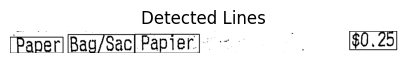

Prediction is: $0.25

Prediction is: Papier.

Prediction is: Rag/Sac

Prediction is: Paner



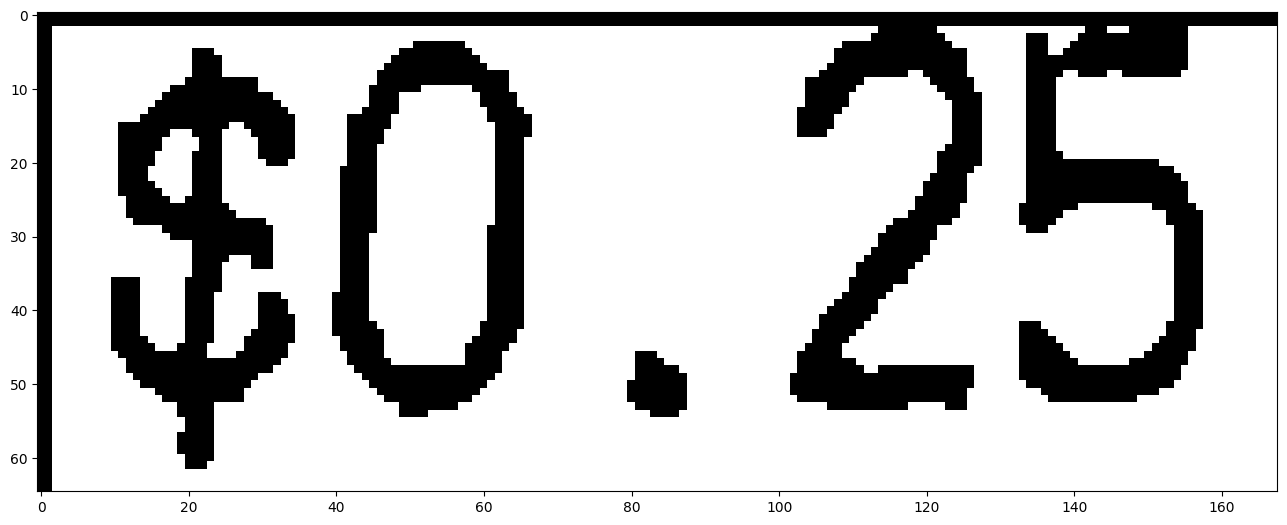

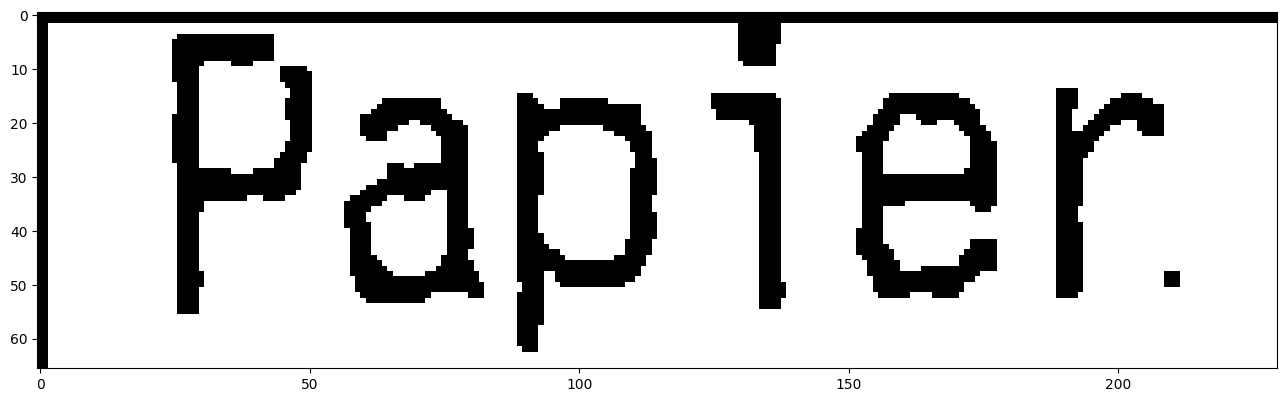

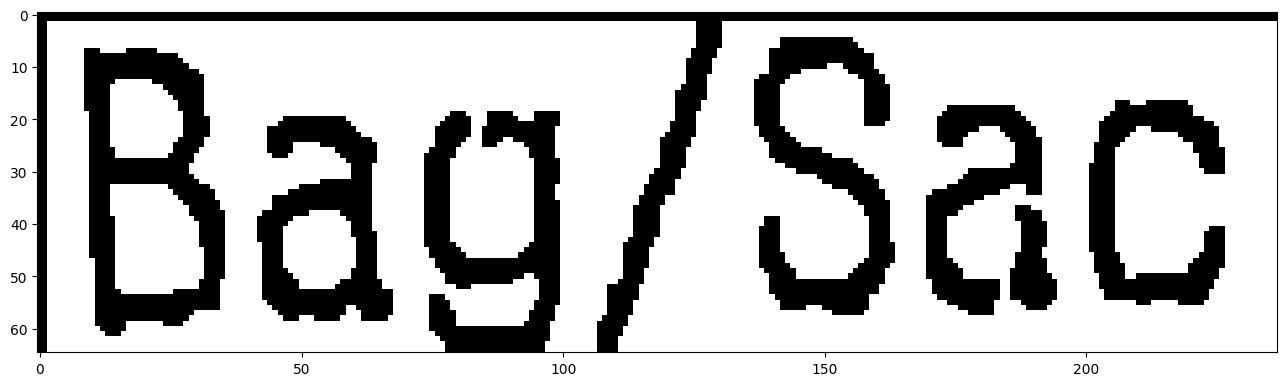

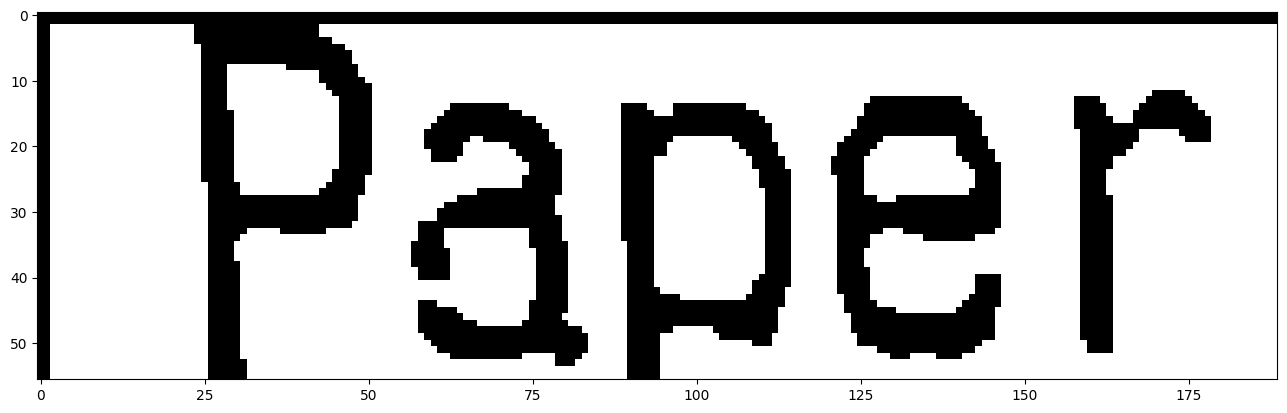

In [27]:
img_path = r"D:\photos\RCNN4\BBOXES\95.jpg"
# img_path = r"D:\photos\SORIE\train\f3652815-bdf8-43f3-b017-093e99cee5fa.jpg"



image = cv2.imread(img_path.replace("\\", "/"))#np array
image = bw_scanner(image)

_, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

kernel = np.ones((5, 20), np.uint8)

dilated_image = cv2.dilate(binary_image, kernel, iterations=1)

contours, _ = cv2.findContours(dilated_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

min_contour_area = 1000
filtered_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

bounding_boxes = [cv2.boundingRect(c) for c in filtered_contours]
bounding_boxes = sorted(bounding_boxes, key=lambda x: x[1])

elements = []
color_image = image
for i, (x, y, w, h) in enumerate(bounding_boxes):
    if w > 20 and h>25:
        line_image = color_image[y:y+h, x:x+w]
        elements.append(line_image)

for (x, y, w, h) in bounding_boxes:
    if w > 20 and h>25:
        cv2.rectangle(color_image, (x, y), (x+w, y+h), (0, 255, 0), 2)
# Plot the image with bounding boxes
plt.figure(figsize=(5, 1))
plt.imshow(color_image, cmap='gray')
plt.title('Detected Lines')
plt.axis('off')
plt.show()

for capture in elements:
    processed_image = preprocess_image(capture)
    plot_gray(processed_image)
    prediction_text = pytesseract.image_to_string(processed_image, lang='eng', config='--psm 8 --oem 3')
    print(f"Prediction is: {prediction_text}")